In [59]:
import sys
sys.path.append(r"D:\往期\QHJ\ZERO")
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sqlalchemy import create_engine

import pymysql

from tools import *

In [5]:
conn = pymysql.Connect(**MYSQL_MALL_DIC)
cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)
engine_conn = "mysql+pymysql://{user}:{password}@{host}:{port}/{database}".format(**MYSQL_MALL_DIC)
engine = create_engine(engine_conn,encoding='utf-8')

In [6]:
order_df = pd.read_sql('select * from order_details where 下单时间>="2019-12-01 00:00:00"',engine)
goods_df = pd.read_sql('select * from goods',engine)
# cursor.execute('select * from order_details where 下单时间>="2019-12-01 00:00:00"')
# d = cursor.fetchall()

In [10]:
df.columns

Index(['订单号', '运单号', '商品ID', '快递公司', '发货商_x', 'goods_type', '数量', '支付金额',
       '收件人', '联系方式', '收货地址', '导出订单时间', '下单时间', '支付时间', '发货时间', '用户名', '用户ID',
       '用户电话', '用户等级', '揽件时间', '退订时间', '送达时间', '拒收时间', '签收时间', '坐标类型', 'lng',
       'lat', 'lastupdate', '备注', '国家', '省份', '城市', '县区', '街道', 'SPUID',
       'goods_name', '系统分类', '市场价', '成本价', '售价', '发货商_y', '发货商ID', '规格', '单位'],
      dtype='object')

In [22]:
free_order = order_df[order_df['goods_type']=="free"]

df = pd.merge(free_order,goods_df[["商品ID","SPUID","goods_name",'系统分类','市场价','成本价','售价','发货商','发货商ID','规格','单位']],on='商品ID',how='left')

In [19]:
df_r = df[['goods_name','订单号','国家','省份','城市','县区']]
df_r = df_r.replace({"goods_name":{r".+?\((.+?)\)$":r"\1"}},regex=True)

dt = pd.pivot_table(df_r,
         index=['国家','省份','城市','县区'],
         columns=['goods_name'],
         values=['订单号'],
         aggfunc={'订单号':"count"} ,fill_value=0,
               margins=True,
               margins_name="总计"
        )
dt = dt.stack(level=0).reset_index(level=-1,drop=True)
dt.columns.name = "三金护肤产品"
dt = dt[['水光针','补水','美肤','护肤','总计']].sort_index(level=1,ascending=False)

In [23]:
df.columns

Index(['订单号', '运单号', '商品ID', '快递公司', '发货商_x', 'goods_type', '数量', '支付金额',
       '收件人', '联系方式', '收货地址', '导出订单时间', '下单时间', '支付时间', '发货时间', '用户名', '用户ID',
       '用户电话', '用户等级', '揽件时间', '退订时间', '送达时间', '拒收时间', '签收时间', '坐标类型', 'lng',
       'lat', 'lastupdate', '备注', '国家', '省份', '城市', '县区', '街道', 'SPUID',
       'goods_name', '系统分类', '市场价', '成本价', '售价', '发货商_y', '发货商ID', '规格', '单位'],
      dtype='object')

订单号                
三金商品         护肤  水光针   美肤    补水
下单日期                           
2019-12-12  4.0  1.0  5.0  32.0
2019-12-13  NaN  NaN  2.0   3.0
2019-12-14  NaN  NaN  3.0   8.0
2019-12-15  1.0  NaN  2.0   9.0
2019-12-16  2.0  1.0  NaN   4.0
2019-12-17  1.0  NaN  4.0  14.0
2019-12-18  NaN  NaN  4.0   2.0

In [85]:
df_r = df[['goods_name','下单时间','订单号']]
df_r = df_r.replace({"goods_name":{r".+?\((.+?)\)$":r"\1"}},regex=True)
df_r['下单日期'] = df_r['下单时间'].apply(lambda x:x.strftime('%Y-%m-%d'))
df_r.sort_values(by=['goods_name','下单时间'],inplace=True)

df_r = df_r[['goods_name','下单日期','订单号']]
df_r.rename(columns={"goods_name":"三金商品"},inplace=True)
df_r = df_r.groupby(['三金商品','下单日期']).count()
df_r = df_r.unstack(level=0).fillna(0)
df_r = df_r.stack(level=0).reset_index(level=-1,drop=True)

In [79]:
df_r

订单号                
三金商品         护肤  水光针   美肤    补水
下单日期                           
2019-12-12  4.0  1.0  5.0  32.0
2019-12-13  0.0  0.0  2.0   3.0
2019-12-14  0.0  0.0  3.0   8.0
2019-12-15  1.0  0.0  2.0   9.0
2019-12-16  2.0  1.0  0.0   4.0
2019-12-17  1.0  0.0  4.0  14.0
2019-12-18  0.0  0.0  4.0   2.0

In [89]:

plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False


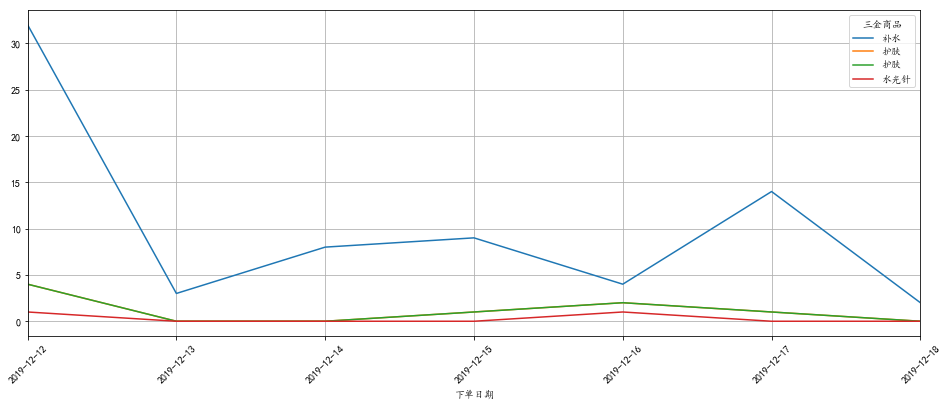

In [88]:
df_r[['补水','护肤','护肤','水光针']].plot(kind='line',figsize=(16,6),rot = 45,
       grid = True)

In [95]:
free_order.to_excel(r"C:\Users\qhj01\Desktop\TTTT.xlsx")